# **Model Training & Testing Notebook**

## **PyTorch Setup**

The first step is to set up our notebook for PyTorch.

In [1]:
# Prepare notebook for PyTorch:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(device)

mps


Next, let's load in our dataset. Recall that we resized our images to be 224 by 224 pixels in the data preprocessing notebook. Because MLP models and CNN models require different types of input, the next code cell will just generically load in the data. We also need to make sure that the labels are displayed correctly to the models, so we'll format them like make_model (i.e., "Toyota_Camry). This step probably should have been done in the data preprocessing notebook but it was a slight oversight.

## **Load Entire Dataset** 

In [21]:
# Imports for combining labels:
import os
from PIL import Image
from torch.utils.data import Dataset

# Class that combines make & model names (like a custom ImageFolder):
class MakeModelCombinedDataset(Dataset):
    IMG_EXTS = {".jpg", ".jpeg"}

    def __init__(self, root, transform=None):
        self.samples = []  # list of (path, class_name)
        self.transform = transform

        for make in sorted(os.listdir(root)):
            make_dir = os.path.join(root, make)
            if not os.path.isdir(make_dir):
                continue
            for model in sorted(os.listdir(make_dir)):
                model_dir = os.path.join(make_dir, model)
                if not os.path.isdir(model_dir):
                    continue
                class_name = f"{make}_{model}"
                for fname in sorted(os.listdir(model_dir)):
                    _, ext = os.path.splitext(fname)
                    if ext.lower() in self.IMG_EXTS:
                        self.samples.append((os.path.join(model_dir, fname), class_name))

        classes = sorted({c for _, c in self.samples})
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.classes = classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, class_name = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[class_name]
        return img, label

### **No Image Agumentation**

In [ ]:
# Imports for loading images:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Common transformations (since we already did resizing, we just need to load the images onto Tensors and normalize them):
common_transforms  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use ImageLoader:
train_dataset = MakeModelCombinedDataset(root="Final_Dataset/train", transform=common_transforms)
val_dataset = MakeModelCombinedDataset(root="Final_Dataset/val", transform=common_transforms)
test_dataset = MakeModelCombinedDataset(root="Final_Dataset/test", transform=common_transforms)

# Use DataLoader:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle the training data to prevent memorization.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Validation set doesn't need shuffling because we want consistent evaluation.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Testing set doesn't need shuffling because we want consistent evaluation.

# Check to see that our combinations are correct:
print("Number of classes:", len(train_dataset.classes))
print("Sample class labels:", train_dataset.classes[:10])

### **Image Augmentation**

In [ ]:
# Imports for loading images:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode as IM

# Advanced transformations to (hopefully) improve accuracy.

IMG_SIZE = 224 # Our images are 224 by 224.

# Training image augmentation can be more liberal than validation image augmentation.
# Test set uses the same transformations as validation set.
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.95, 1.05), interpolation=IM.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),  # horizontal is fine for cars; avoid vertical
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.02),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=2, interpolation=IM.BICUBIC),  # gentle geometry
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random')
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15), interpolation=IM.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use ImageLoader:
train_dataset = MakeModelCombinedDataset(root="Final_Dataset/train", transform=train_tfms)
val_dataset = MakeModelCombinedDataset(root="Final_Dataset/val", transform=val_tfms)
test_dataset = MakeModelCombinedDataset(root="Final_Dataset/test", transform=val_tfms)

# Use DataLoader:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle the training data to prevent memorization.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Validation set doesn't need shuffling because we want consistent evaluation.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Testing set doesn't need shuffling because we want consistent evaluation.

# Check to see that our combinations are correct:
print("Number of classes:", len(train_dataset.classes))
print("Sample class labels:", train_dataset.classes[:10])

## **Load Partial Dataset** 

In [3]:
# Imports for combining labels:
import os
from PIL import Image
from torch.utils.data import Dataset

# Random module:
import random

# Class that combines make & model names (like a custom ImageFolder):
# This only returns 20% of images, useful for quick runs.
class MakeModelCombinedDatasetPartial(Dataset):
    IMG_EXTS = {".jpg", ".jpeg"}

    def __init__(self, root, transform=None):
        self.samples = []  # list of (path, class_name)
        self.transform = transform

        for make in sorted(os.listdir(root)):
            make_dir = os.path.join(root, make)
            if not os.path.isdir(make_dir):
                continue
            for model in sorted(os.listdir(make_dir)):
                model_dir = os.path.join(make_dir, model)
                if not os.path.isdir(model_dir):
                    continue
                class_name = f"{make}_{model}"

                imgs = []
                for fname in sorted(os.listdir(model_dir)):
                    _, ext = os.path.splitext(fname)
                    if ext.lower() in self.IMG_EXTS:
                        '''
                        self.samples.append((os.path.join(model_dir, fname), class_name))
                        '''
                        imgs.append((os.path.join(model_dir, fname), class_name))

                '''
                Only use 20% of the actual dataset
                '''
                # Shuffle the imgs for randomization
                random.shuffle(imgs)
                # Max to guareentee an integer
                kept_size = max(1, int(len(imgs) * 0.2))
                # Set the split the array to samples
                self.samples.extend(imgs[:kept_size])

        classes = sorted({c for _, c in self.samples})
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.classes = classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, class_name = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[class_name]
        return img, label

### **No Image Augmentation**

In [ ]:
# Imports for loading images:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Common transformations (since we already did resizing, we just need to load the images onto Tensors and normalize them):
common_transforms  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use ImageLoader:
train_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/train", transform=common_transforms)
val_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/val", transform=common_transforms)
test_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/test", transform=common_transforms)

# Use DataLoader:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle the training data to prevent memorization.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Validation set doesn't need shuffling because we want consistent evaluation.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Testing set doesn't need shuffling because we want consistent evaluation.

# Check to see that our combinations are correct:
print("Number of classes:", len(train_dataset.classes))
print("Sample class labels:", train_dataset.classes[:10])

Number of classes: 102
Sample class labels: ['Audi_A3', 'Audi_A4', 'Audi_A6', 'BMW_1', 'BMW_3', 'BMW_5', 'Chevrolet_Aveo', 'Chevrolet_Cruze', 'Citroen_Berlingo', 'Citroen_C-Elysee']


### **Image Augmentation**

In [4]:
# Imports for loading images:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode as IM

# Advanced transformations to (hopefully) improve accuracy.

IMG_SIZE = 224 # Our images are 224 by 224.

# Training image augmentation can be more liberal than validation image augmentation.
# Test set uses the same transformations as validation set.
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.95, 1.05), interpolation=IM.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),  # horizontal is fine for cars; avoid vertical
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.02),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=2, interpolation=IM.BICUBIC),  # gentle geometry
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random')
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15), interpolation=IM.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use ImageLoader:
train_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/train", transform=train_tfms)
val_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/val", transform=val_tfms)
test_dataset = MakeModelCombinedDatasetPartial(root="Final_Dataset/test", transform=val_tfms)

# Use DataLoader:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle the training data to prevent memorization.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Validation set doesn't need shuffling because we want consistent evaluation.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Testing set doesn't need shuffling because we want consistent evaluation.

# Check to see that our combinations are correct:
print("Number of classes:", len(train_dataset.classes))
print("Sample class labels:", train_dataset.classes[:10])

Number of classes: 102
Sample class labels: ['Audi_A3', 'Audi_A4', 'Audi_A6', 'BMW_1', 'BMW_3', 'BMW_5', 'Chevrolet_Aveo', 'Chevrolet_Cruze', 'Citroen_Berlingo', 'Citroen_C-Elysee']


Looks good :)

## **Functions**

### **Train Only**

We can write a generic training function for both models to simplify our code.

In [ ]:
# Generic model training function:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device='cpu'):

    # Keep track of our model's performance:
    train_losses = []
    train_accuracies = []

    model = model.to(device)
    for epoch in range(num_epochs):
        model.train() # Set model to training mode.

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Clear previous gradients:
            optimizer.zero_grad()

            # Forward pass:
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass:
            loss.backward()
            optimizer.step()

            # Update loss:
            running_loss = running_loss + loss.item()

            # Calculate accuracy:
            _, predicted = torch.max(outputs, 1)
            correct = correct + (predicted == labels).sum().item()
            total = total + labels.size(0)

        # Calculate average training loss and accuracy for the epoch:
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        # Store metrics for plotting:
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Print progress:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {avg_epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

    return train_losses, train_accuracies

### **Evaluate Only**

Similarly, we can create a generic function that will evaluate the models' performance. This function will be used for both the validation and test sets!

In [ ]:
# Generic model evaluation function:
def evaluate_model(model, data_loader, criterion, device='cpu'):

    # Keep track of evaluation metrics:
    evaluation_losses = []
    evaluation_accuracies = []
    
    model = model.to(device)
    model.eval() # Set model to evaluation mode.

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient calculation because we aren't updating weights and biases.
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update loss:
            running_loss = running_loss + loss.item()

            # Calculate accuracy:
            _, predicted = torch.max(outputs, 1)
            correct = correct + (predicted == labels).sum().item()
            total = total + labels.size(0)

    # Calculate average evaluation loss and accuracy:
    average_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    # Store metrics for plotting:
    evaluation_losses.append(average_loss)
    evaluation_accuracies.append(accuracy)

    # Print results:
    print(f"Evaluation Loss: {average_loss:.4f}, Evaluation Accuracy: {accuracy:.2f}%")

    return evaluation_losses, evaluation_accuracies

### **Train and Evaluate (use this to plot)**

Here's one that combines both training and testing (prefer this to plot)!

In [5]:
def train_and_evaluate(model, train_loader, data_loader, criterion, optimizer, num_epochs, device='cpu'):

    model = model.to(device)

    train_losses, train_accuracies = [], []
    eval_losses, eval_accuracies = [], []

    for epoch in range(num_epochs):
        # ---------------------- TRAINING ----------------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Track loss
            running_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")


        # ---------------------- EVALUATION ----------------------
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_eval_loss = running_loss / len(data_loader)
        eval_acc = 100 * correct / total

        eval_losses.append(avg_eval_loss)
        eval_accuracies.append(eval_acc)

        print(f"Eval Loss: {avg_eval_loss:.4f} | Eval Acc: {eval_acc:.2f}%")

    return train_losses, train_accuracies, eval_losses, eval_accuracies

### **Plot**

And finally, generic plotters for the losses and accuracies of the training and evaluation sets.

In [6]:
# Imports for plotting:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, evaluation_losses, evaluation_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot for loss:
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, evaluation_losses, label='Evaluation Loss', color='red', linestyle='-', marker='x')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, evaluation_accuracies, label='Evaluation Accuracy', color='red', linestyle='-', marker='x')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **Multi-Layer Perceptron (Baseline Model):**

For our baseline model, we will use a shallow multilayer perceptron. The general structure of a MLP model is as follows:

- *Input Layer*: The first layer that receives the input data. Each node in this layer represents a feature of the input data.

- *Hidden Layer(s)*: One or more layers between the input and output layers. Each node in these layers performs a weighted sum of inputs, applies an activation function, and passes the result to the next layer.

- *Output Layer*: The final layer that produces the prediction or output of the model. The number of neurons in this layer corresponds to the number or classes for classification problems or a single value for regression problems.

- *Weights & Biases*: Connections between neurons have associated weights, and each neuron has a bias. These parameters are learned during training to minimize the loss function.

- *Activation Functions*: Nonlinear functions such as ReLU, Sigmoid, and Tanh are applied to the output of each neuron to introduce non-linearity, which allows the network to model complex relationships.

An MLP is also fully-connected, meaning that each neuron in one layer is connected to every neuron in the next layer. 

**Note:** Multilayer perceptrons require image-flattening into a 1-D vector

In [21]:
# Imports for MLP:
import torch.nn as nn
import torch.optim as optim

# Create MLP model class:
class MLP(nn.Module):
    def __init__(self, input_dims, num_classes):
        super(MLP, self).__init__()
        
        # Keep the network shallow for now:
        self.fc1 = nn.Linear(input_dims, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten the image tensor into a 1-D vector.
        x = torch.relu(self.fc1(x)) # Apply activation functions after each layer.
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # Output logits.
        return x

In [22]:
# Define the MLP model:
MLP_model = MLP(input_dims=224*224*3, num_classes=len(train_dataset.classes))

In [23]:
# Define the loss function and optimizer:
criterion = nn.CrossEntropyLoss()
MLP_optimizer = optim.Adam(MLP_model.parameters(), lr=0.001)

In [24]:
# Train MLP:
MLP_train_losses, MLP_train_accuracies, MLP_evaluation_losses, MLP_evaluation_accuracies = train_and_evaluate(MLP_model, train_loader, val_loader, criterion, MLP_optimizer, num_epochs=10)

Epoch [1/10] | Train Loss: 4.7884 | Train Acc: 4.30%
Eval Loss: 4.2315 | Eval Acc: 5.04%
Epoch [2/10] | Train Loss: 4.2309 | Train Acc: 5.25%
Eval Loss: 4.2270 | Eval Acc: 5.04%
Epoch [3/10] | Train Loss: 4.2113 | Train Acc: 5.04%
Eval Loss: 4.1986 | Eval Acc: 5.70%
Epoch [4/10] | Train Loss: 4.1901 | Train Acc: 5.19%
Eval Loss: 4.1938 | Eval Acc: 5.46%
Epoch [5/10] | Train Loss: 4.1820 | Train Acc: 5.41%
Eval Loss: 4.2116 | Eval Acc: 4.86%
Epoch [6/10] | Train Loss: 4.1886 | Train Acc: 5.41%
Eval Loss: 4.2045 | Eval Acc: 5.34%
Epoch [7/10] | Train Loss: 4.1838 | Train Acc: 5.66%
Eval Loss: 4.1859 | Eval Acc: 5.76%
Epoch [8/10] | Train Loss: 4.1856 | Train Acc: 5.52%
Eval Loss: 4.2204 | Eval Acc: 4.80%
Epoch [9/10] | Train Loss: 4.1830 | Train Acc: 5.37%
Eval Loss: 4.1937 | Eval Acc: 5.34%
Epoch [10/10] | Train Loss: 4.1790 | Train Acc: 5.60%
Eval Loss: 4.2464 | Eval Acc: 4.56%


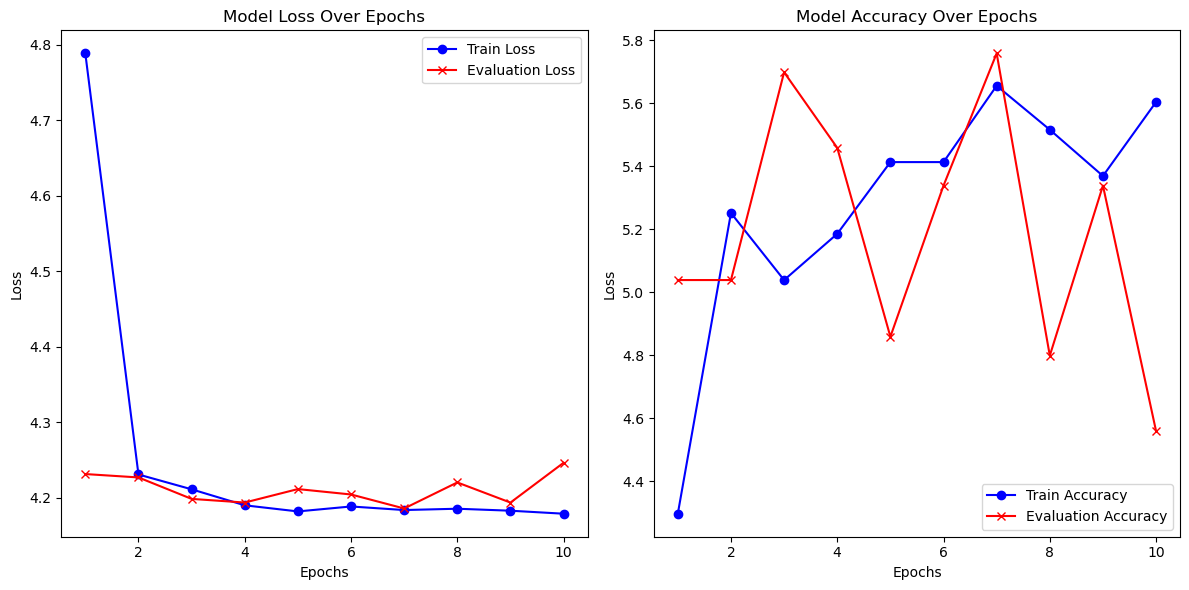

In [25]:
# Graph the loss and accuracy:
plot_metrics(MLP_train_losses, MLP_train_accuracies, MLP_evaluation_losses, MLP_evaluation_accuracies)


In [9]:
# Evaluate MLP on test set: 
# DO NOT FILL IN THIS CODE CELL UNTIL AFTER HYPERPARAMETER TUNING!!!

## **Convolutional Neural Network:**

We expect that a CNN will perform much better overall than the MLP due to its ability to preserve spatial features. So, we will focus on tuning the CNN more. The general structure of a CNN is as follows:

- *Input Layer*: The input layer takes in the raw data (usually images), represented as a grid of pixels (i.e., width * height * color channels = 32 * 32 * 3).

- *Convolutional Layer(s)*: These layers apply convolutional filters (A.K.A. kernels) to the input or previous layer. Each filter detects specific features, such as edges or textures. These features are learned during training. The result is a set of feature maps, which highlight areas of the input that match the learned features.

- *Activation Functions*: After convolution, an activation function (usually ReLU) is applied to introduce non-linearity. This helps the network learn more complex patterns.

- *Pooling Layers*: Pooling layers (usually Max Pooling) reduce the spatial dimensions (width and height) of the feature maps. This helps reduce computation and makes the network more invariant to small translations of the input (i.e., shifting or zooming in an image). Essentially, pooling retains the most important features of the input data.

- *Fully-Connected Layers*: After several convolutional and pooling layers, the data is flattened into a 1-D vector and passed through one or more fully-connected layers. These layers are similar to those in a traditional MLP and are used to make the final classification or regression prediction.

- *Output Layer*: The final layer produces the output of the network. For classification tasks, this typically uses a softmax activation function (assuming multi-class classification) or sigmoid (assuming binary classification) to output probabilities.

- *Weights and Biases*: Like an MLP, CNNs have weights and biases that are learned during training through backpropagation.

**Note:** Convolutional neural networks do not require images to be flattened beforehand.

In [16]:
# Imports for CNN:
import torch.nn as nn
import torch.optim as optim

# Create CNN model class:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # Keep the network shallow for now:
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*56*56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
# Define the CNN model:
CNN_model = CNN(num_classes=len(train_dataset.classes))

In [18]:
# Define the loss function and optimizer:
criterion = nn.CrossEntropyLoss()
CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

In [19]:
# Train CNN:
CNN_train_losses, CNN_train_accuracies, CNN_evaluation_losses, CNN_evaluation_accuracies = train_and_evaluate(CNN_model, train_loader, val_loader, criterion, CNN_optimizer, num_epochs=10, device=device)

Epoch [1/10] | Train Loss: 4.4458 | Train Acc: 4.94%
Eval Loss: 4.2233 | Eval Acc: 4.98%
Epoch [2/10] | Train Loss: 4.1898 | Train Acc: 5.60%
Eval Loss: 4.1620 | Eval Acc: 5.46%
Epoch [3/10] | Train Loss: 4.1466 | Train Acc: 6.26%
Eval Loss: 4.1458 | Eval Acc: 5.34%
Epoch [4/10] | Train Loss: 4.1175 | Train Acc: 6.30%
Eval Loss: 4.1427 | Eval Acc: 6.48%
Epoch [5/10] | Train Loss: 4.0800 | Train Acc: 7.04%
Eval Loss: 4.0843 | Eval Acc: 6.66%
Epoch [6/10] | Train Loss: 4.0346 | Train Acc: 7.94%
Eval Loss: 4.0692 | Eval Acc: 8.04%
Epoch [7/10] | Train Loss: 3.9870 | Train Acc: 8.85%
Eval Loss: 4.0565 | Eval Acc: 8.46%
Epoch [8/10] | Train Loss: 3.9336 | Train Acc: 9.75%
Eval Loss: 3.9842 | Eval Acc: 8.88%
Epoch [9/10] | Train Loss: 3.8834 | Train Acc: 10.60%
Eval Loss: 3.9464 | Eval Acc: 9.96%
Epoch [10/10] | Train Loss: 3.8305 | Train Acc: 11.33%
Eval Loss: 3.9067 | Eval Acc: 10.56%


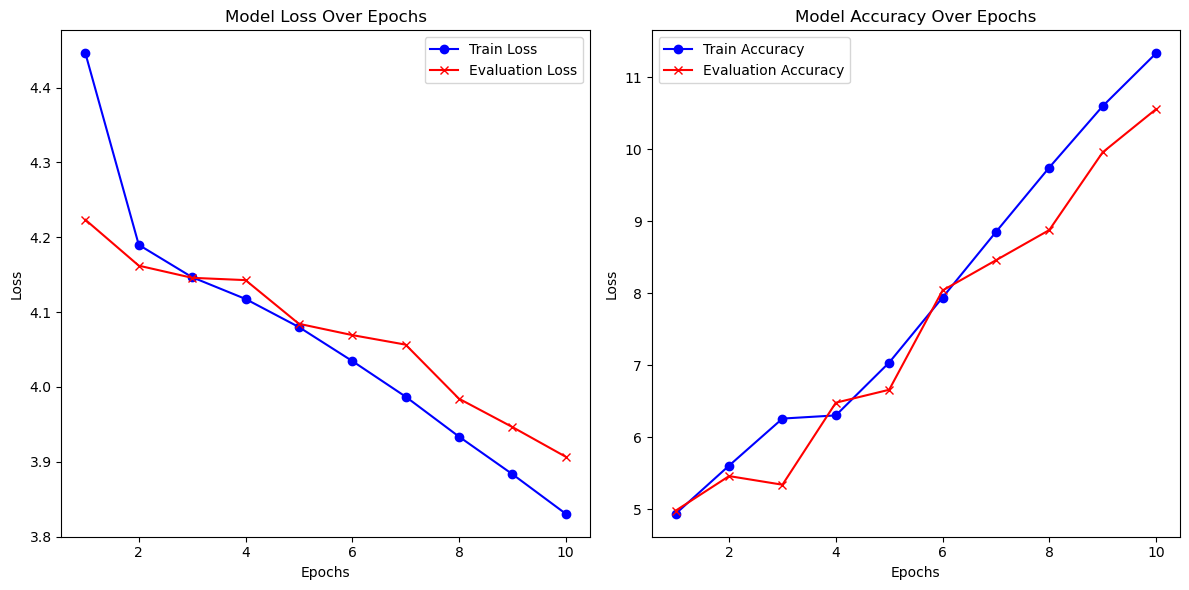

In [20]:
# Graph the losses and accuracies:
plot_metrics(CNN_train_losses, CNN_train_accuracies, CNN_evaluation_losses, CNN_evaluation_accuracies)

In [14]:
# Evaluate CNN on test set: 
# DO NOT FILL IN THIS CODE CELL UNTIL AFTER HYPERPARAMETER TUNING!!!